In [6]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

from tqdm import tqdm

## Evaluation of optimal alpha and delta

Contents:
- Grid search like
    - Alpha
    - Delta
- Joint optimization
    - Alpha
    - Both at same time

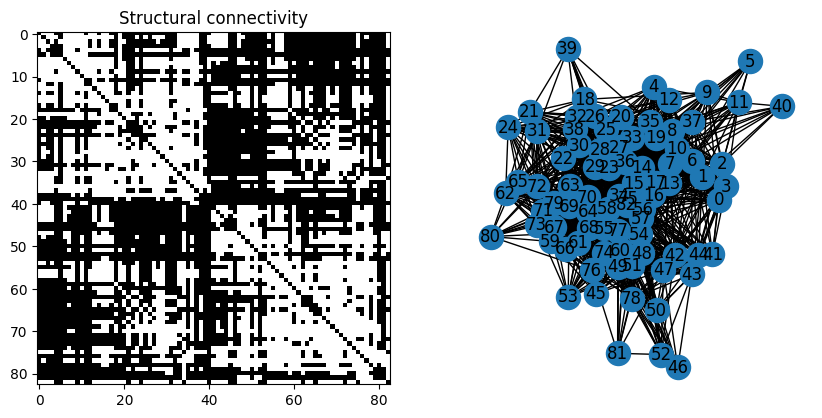

In [28]:
path_to_data = "../resources"

# Could be 50, 100, 200, 400
delay_max = 400
path_to_ftract = f"../../atlas_data/F-TRACT-090624/{delay_max}"

filename = "bundle_probability_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))

adj = adj[:83, :83]
adj -= np.diag(np.diag(adj))

bundle_prob_thresh = 0.9

adj = (adj > bundle_prob_thresh).copy().astype(int)

bundle_prob = utils.load(op.join(path_to_data, "bundle_probability_atlas.pkl"))
bundle_prob = bundle_prob[:83, :83]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = utils.load(op.join(path_to_data, "adj_probability_ftract.pkl"))
ftract_prob = ftract_prob[:83, :83]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

In [24]:
with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

prob_thresh = 0
y_ground_mat *= ftract_prob > prob_thresh
y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [37]:
import os
if os.path.exists(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl'):
    design_matrices_subopts = utils.load(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl')
else:
    design_matrices_subopts = []
    for k in tqdm(range(2)):
        design_matrices_subopts.append(regmod.get_shortest_matrices(adjacency=adj, n_subopt=k))

    utils.save(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl', design_matrices_subopts)

### Grid search like - Varying Alpha

In [38]:
max_path_depth = 1
alpha_space = np.linspace(0, 2, 21)

alphas_results = {}
for alpha in tqdm(alpha_space):
    design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
    design_model = solver.torch.tensor(design_shortest)

    # Define mapping area
    non_zero_mask = y_ground > 0
    y_masked = y_ground[non_zero_mask]
    design_model_masked = design_model[non_zero_mask]

    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)
    
    alphas_results[alpha] = (x_opt,loss)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  5%|▍         | 1/21 [01:27<29:14, 87.71s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 10%|▉         | 2/21 [02:56<28:01, 88.47s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 14%|█▍        | 3/21 [04:24<26:30, 88.37s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 19%|█▉        | 4/21 [05:56<25:21, 89.52s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 24%|██▍       | 5/21 [07:35<24:47, 92.95s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 29%|██▊       | 6/21 [09:03<22:49, 91.30s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 33%|███▎      | 7/21 [10:33<21:12, 90.90s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 38%|███▊      | 8/21 [12:19<20:44, 95.74s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 43%|████▎     | 9/21 [14:13<20:17, 101.49s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 48%|████▊     | 10/21 [15:41<17:49, 97.24s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 52%|█████▏    | 11/21 [17:15<16:03, 96.36s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 57%|█████▋    | 12/21 [19:19<15:42, 104.69s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 62%|██████▏   | 13/21 [21:14<14:22, 107.78s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 67%|██████▋   | 14/21 [23:00<12:30, 107.22s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 71%|███████▏  | 15/21 [24:27<10:06, 101.11s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 76%|███████▌  | 16/21 [26:19<08:42, 104.50s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 81%|████████  | 17/21 [29:20<08:30, 127.56s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 86%|████████▌ | 18/21 [30:53<05:51, 117.21s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 90%|█████████ | 19/21 [32:21<03:36, 108.30s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 95%|█████████▌| 20/21 [33:48<01:41, 101.77s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 21/21 [35:14<00:00, 100.70s/it]


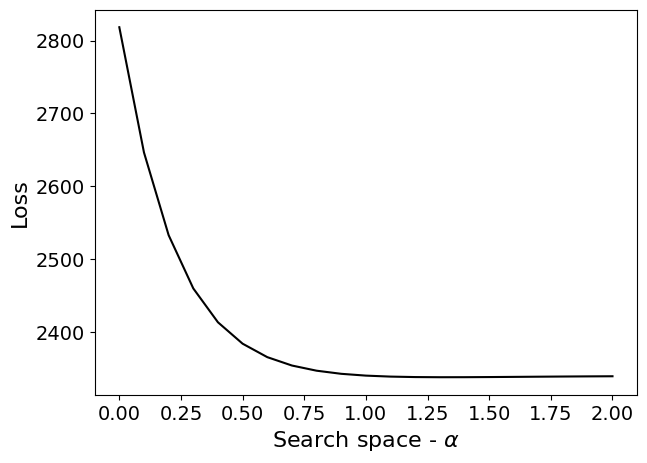

In [97]:
fig, ax = plt.subplots(1, figsize=(7, 5))
losses = [alphas_results[alpha][1] for alpha in alpha_space]
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel(r'Search space - $\alpha$', fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(alpha_space, losses, color='k')
# ax.scatter([alpha_space[1], alpha_space[17]], [losses[1], losses[17]], 100, c='r', marker='x', label='local minima')
# ax.legend(prop={'size': 16})

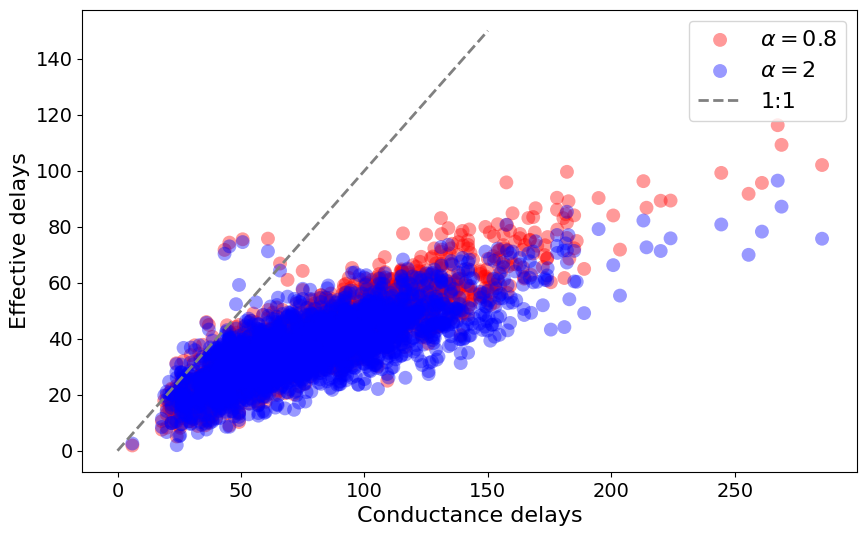

In [107]:
# plot the mapping curve and see what it looks like

x1 = alphas_results[0.8][0]
x2 = alphas_results[2][0]
y = y_ground

x1_mask = x1 > 1
x2_mask = x2 > 1
y_mask = y != 0
xy_mask1 = np.logical_and(x1_mask, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x2_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(y[xy_mask1], x1[xy_mask1], s=100, alpha=.4, edgecolors="none", color='red', label=r'$\alpha=0.8$')
ax.scatter(y[xy_mask2], x2[xy_mask2], s=100, alpha=.4, edgecolors="none", color='blue', label=r'$\alpha=2$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=16)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

### Grid search like - Varying Delta

In [40]:
max_path_depth = 1

delta_space = np.linspace(0, 60, 21)
alpha = 0.8

design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
design_model = solver.torch.tensor(design_shortest)

delta_results = {}
for delta in tqdm(delta_space):

    # Define mapping area
    non_zero_mask = y_ground > 0
    y_masked = y_ground[non_zero_mask]
    design_model_masked = design_model[non_zero_mask]

    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=delta,
                                            l2_penalty=1)
    
    delta_results[delta] = (x_opt,loss)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  5%|▍         | 1/21 [04:21<1:27:05, 261.30s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 10%|▉         | 2/21 [14:28<2:27:15, 465.01s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 14%|█▍        | 3/21 [15:51<1:27:07, 290.44s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 19%|█▉        | 4/21 [17:13<58:57, 208.11s/it]  

  0%|          | 0/10000 [00:00<?, ?it/s]

 24%|██▍       | 5/21 [18:37<43:33, 163.33s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 29%|██▊       | 6/21 [20:01<34:04, 136.28s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 33%|███▎      | 7/21 [21:24<27:47, 119.12s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 38%|███▊      | 8/21 [22:47<23:17, 107.49s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 43%|████▎     | 9/21 [24:10<19:59, 99.92s/it] 

  0%|          | 0/10000 [00:00<?, ?it/s]

 48%|████▊     | 10/21 [25:34<17:23, 94.86s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 52%|█████▏    | 11/21 [1:38:43<3:54:51, 1409.20s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 57%|█████▋    | 12/21 [1:40:08<2:30:57, 1006.40s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 62%|██████▏   | 13/21 [2:13:51<2:55:14, 1314.34s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 67%|██████▋   | 14/21 [2:15:15<1:49:57, 942.53s/it] 

  0%|          | 0/10000 [00:00<?, ?it/s]

 71%|███████▏  | 15/21 [2:16:37<1:08:19, 683.26s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 76%|███████▌  | 16/21 [2:18:00<41:53, 502.69s/it]  

  0%|          | 0/10000 [00:00<?, ?it/s]

 81%|████████  | 17/21 [2:19:22<25:04, 376.17s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 86%|████████▌ | 18/21 [2:20:45<14:24, 288.01s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 90%|█████████ | 19/21 [2:22:09<07:33, 226.54s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 95%|█████████▌| 20/21 [2:23:32<03:03, 183.52s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 21/21 [2:24:55<00:00, 414.06s/it]


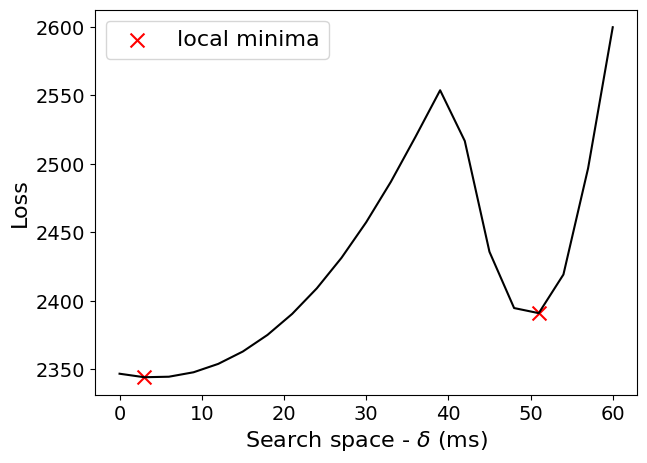

In [77]:
fig, ax = plt.subplots(1, figsize=(7, 5))
losses = [delta_results[delta][1] for delta in delta_space]
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel(r'Search space - $\delta$ (ms)', fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(delta_space, losses, color='k')
ax.scatter([delta_space[1], delta_space[17]], [losses[1], losses[17]], 100, c='r', marker='x', label='local minima')
ax.legend(prop={'size': 16})

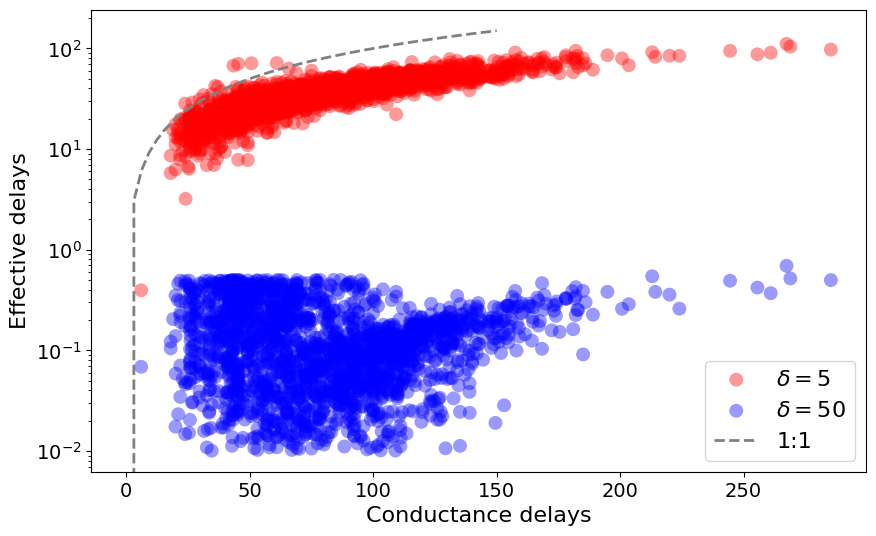

In [92]:
# plot the mapping curve and see what it looks like
x1 = delta_results[delta_space[1]][0]
x2 = delta_results[delta_space[17]][0]
y = y_ground

x_mask1 = x1 > 1e-2
x_mask2 = x2 > 1e-2
y_mask = y != 0
xy_mask1 = np.logical_and(x_mask1, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x_mask2, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(y[xy_mask1], x1[xy_mask1], s=100, alpha=.4, edgecolors="none", color='red', label=r'$\delta=5$')
ax.scatter(y[xy_mask2], x2[xy_mask2], s=100, alpha=.4, edgecolors="none", color='blue', label=r'$\delta=50$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.set_yscale('log')
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
ax.legend(fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [45]:
utils.save('../resources/alpha_varying.pkl', (alpha_space, alphas_results))
utils.save('../resources/delta_varying.pkl', (delta_space, delta_results))

### Joint Optimization - Alpha

In [ ]:
from src import regmod_torch

In [ ]:
# TODO: Quickly Check porting to tensor gives same results as original

regmod_torch.apply_alpha_to_design_torch == regmod.apply_alpha_to_design

### Joint Optimization - Delta